# Convolutional Neural Network 이란?


Convolutional Neural Network(이하 CNN)은 대표적인 Deep Neural Network의 종류 중 하나로 데이터로부터 Feature를 추출하려고 할때 주로 사용된다. 데이터를 분석할 때 보통 모든 데이터를 분석하기 보다 데이터로부터 의미 있는 몇몇의 요소를 추출해서 분석한다. 이러한 과정을 feature extraction이라고 한다. 기존의 기계학습 방법들은 이러한 feature extraction을 사람이 직접 알고리즘을 설계해서 했다. 그러나 CNN은 이러한 feature를 모델이 스스로 학습하여 추출하며 사람이 직접 디자인한 알고리즘으로 추출할때보다 성능도 잘 나오고 간단하기 때문에 많이 사용되고 있다. CNN은 이미지 뿐만 아니라 텍스트, 음성 데이터등 여러가지의 도메인에도 적용이 가능하다. 

![](CNN_1/typical_cnn.png)
<그림 1. CNN 구조>

# CNN의 구성요소와 정의
- Convolutional Layer: Filter통해 Input data로 부터 특징들(feature map)을 추출하는 Layer임. high level feature를 추출함.
- Stride : Convolution할때 Filter가 움직이는 단위를 의미함. 보통의 경우 1로써 한칸씩 이동함.
- Max/Average pooling Layer: 얻어진 특징들(activation map)에 대해서 일정 영역을 잡아 최대값 또는 평균값을 기준으로(보통은 최대값) 특징들의 크기를 줄여주는 layer임. Sparse representation을 제거함. <br>

![](CNN_1/Max_pooling.png)
<그림 2. Max Pooling 예시>

# CNN으로 MNIST 분석하기
CNN을 사용해서 MNIST데이털르 분석해보자. MNIST는 28x28의 크기를 가진 0-9까지의 숫자로 이루어진 손글씨 이미지 데이터다.
- Training Data 개수: 55,000 
- Test Data 개수 : 10,000 

본 예제에서는 값을 0-1 사이로 정규화해서 사용했다.

In [15]:
#-*- coding: utf-8 -*-
# Tensorflow에서 제공하는 API를 통해 mnist데이터를 다운로드 받는다.
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# 데이터 형태 분석
실제로 데이터가 어떻게 생겼는지 Data의 Shape과 Plotting을 통해 살펴보겠다.

x_train Shape:  (55000, 784)
y_train Shape:  (55000, 10)
x_test Shape:  (10000, 784)
y_test Shape:  (10000, 10)


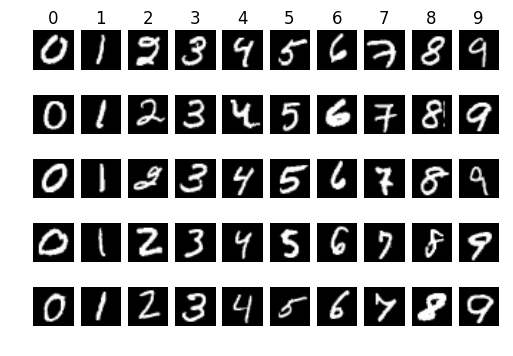

In [2]:
# MNIST 객체로부터 데이터를 받는다.
x_train = mnist.train.images
y_train = mnist.train.labels
x_test = mnist.test.images
y_test = mnist.test.labels

print("x_train Shape: ", x_train.shape)
print("y_train Shape: ", y_train.shape)
print("x_test Shape: ", x_test.shape)
print("y_test Shape: ", y_test.shape)


import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def plot_mnist(data, classes, incorrect=None):
    
    for i in range(10):
        idxs = (classes == i) #조건에 맞는 index만 True 나머지는 False로 리턴된다.
        # 클래스 i에 해당하는 10개의 데이터
        
        if incorrect is not None:
            idxs *= incorrect
        
        images = data[idxs][0:10] #True조건을 만족하는 index로 data를 뽑고 그 중 10개를 뽑는다.
            
        for j in range(5):   
            plt.subplot(5, 10, i + j*10 + 1) # 행, 열, plot번호
            plt.imshow(images[j].reshape(28, 28), cmap='gray')
            # 클래스당 타이틀 표시
            if j == 0:
                plt.title(i)
            plt.axis('off')
    plt.show()

classes = np.argmax(y_train, 1) # [7 3 4 ..., 5 6 8] 형태로 출력된다.
plot_mnist(x_train, classes)

In [3]:
# Tensorflow 모듈을 import한다.
import tensorflow as tf

In [4]:
# Parameter들을 한 곳에 모아서 관리한다.
learning_rate = 1e-4
num_of_iter = 800
batch_size = 50
keep_prob_train = 0.5 # dropout
keep_prob_test= 1.0

## Tensorboard 1
- 정보 저장하기 (tf.summary) <br>

tf.summary는 tensorflow내의 변수들의 정보를 저장하며 이는 Tensorboard를 통해 확인할 수 있다. 아래에서는 (평균, 표준편차, 최대, 최소)의 정보를 저장하기 위한 함수를 정의한다.

In [5]:
def variable_summaries(var, name):  
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean/' + name, mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev/' + name, stddev)
    tf.summary.scalar('max/' + name, tf.reduce_max(var))
    tf.summary.scalar('min/' + name, tf.reduce_min(var))
    tf.summary.histogram(name, var)

## Placeholder
 텐서플로우에서는 Input data를 담는 특별한 변수를 정의하는데 그것이 바로 Placeholder다.<br>
 본 예제에서 MNIST 데이터를 담을 x와 MNIST의 label을 담을 y를 선언하겠다.

In [6]:
# Input data를 담을 변수인 Placeholder를 선언한다.
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")

 ## Weight & Bias (Dictionary Style)
 Weight와 Bias에 대한 변수들을 Dict 형태로 선언한다. 이러한 스타일의 장점은 변수를 재사용하기가 쉽고, 관리하기가 편하다는 것이다.

In [7]:

weights = {
    # cnn 5x5, 1 channel, 32 filters(==outputs)
    'W_conv1': tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1), name='W_conv1'),
    # cnn 5x5, 32 channel, 64 filters(==outputs)
    'W_conv2': tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1), name='W_conv2'),
    # fc 7*7*64 input / 1024 output
    'W_fc1': tf.Variable(tf.truncated_normal([7 * 7 * 64, 1024], stddev=0.1), name='W_fc1'),
    # fc 1024 input / 10 output
    'W_fc2': tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1), name='W_fc2'),
}

biases = {
    'b_conv1': tf.Variable(tf.constant(0.1, shape=[32]), name='b_conv1'),
    'b_conv2': tf.Variable(tf.constant(0.1, shape=[64]), name='b_conv2'),
    'b_fc1': tf.Variable(tf.constant(0.1, shape=[1024]), name='b_fc1'),
    'b_fc2': tf.Variable(tf.constant(0.1, shape=[10]), name='b_fc2'),    
}

for key, value in weights.items():
    variable_summaries(value, key)
for key, value in biases.items():
    variable_summaries(value, key)    

## CNN 모델 구조 
MNIST 데이터를 학습하기 위해 아래와 같은 과정을 거친다.<br>
1. Input 데이터의 Shape 변경(CNN의 input Shape)
2. 1-Layer Convolution 
3. Max pooling
4. 2-Layer Convolution
5. Max pooling
6. 5번의 결과의 Shape 변경(Fully Connected Layer의 Input Shape)
7. Fully Connected Layer
8. Fully Connected Layer
9. 예측값과 라벨값 비교해서 에러(loss) 계산
10. Optimizer로 에러를 줄이기 위해 Weight 값 업데이트


In [8]:
# CNN을 함수 형태로 선언한다. 
def CNN(x, weights, biases, keep_prob):
    
    # Convolution을 하기 위해 Input에 대해서 Reshape한다.
    with tf.name_scope('input_reshape'):
        x_image = tf.reshape(x, [-1,28,28,1], name="x_image_reshape") # (Batch_size, width, height, Dim of Channel)로 변경합니다.
        tf.summary.image('input', x_image, 10)
        print("input x_image shape: ", x_image.get_shape().as_list())
    
    # Convolution과 Pooling 을 정의한다. 
    # Padding이 'SAME'이라는 것은 Zero padding(여백)을 허용한다는 뜻이다.

    # 첫번째 CNN
    with tf.name_scope("Conv_Layer1"):
        conv1 = tf.nn.conv2d(x_image, weights['W_conv1'], strides=[1, 1, 1, 1], padding='SAME') 
        print("1번째 CNN 통과 후 shape: ", conv1.get_shape().as_list())
        h_conv1 = tf.nn.relu(conv1 + biases['b_conv1'], name="h_conv1")    
    
    with tf.name_scope("Pooling_Layer1"):            
        h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='h_pool1')
        print("1번째 Max pooling 통과 후 shape: ", h_pool1.get_shape().as_list())
    
    # 두번째 CNN
    with tf.name_scope("Conv_Layer2"):
        conv2 = tf.nn.conv2d(h_pool1, weights['W_conv2'], strides=[1, 1, 1, 1], padding='SAME') 
        print("2번째 CNN 통과 후 shape: ", conv2.get_shape().as_list())
        h_conv2 = tf.nn.relu(conv2 + biases['b_conv2'], name="h_conv2")
        
    h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='h_pool2')    
    print("2번째 Max pooling 통과 후 shape: ", h_pool2.get_shape().as_list())
    
    with tf.name_scope("Pooling_Layer2"):
        # 결과를 FC Layer에 넣기 위해 일렬로 펴기
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64], name="h_pool2_flat")
        print("Flat할 때 shape: ", h_pool2_flat.get_shape().as_list())
    
    # 첫번째 FC Layer
    with tf.name_scope("FC_Layer1"):
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, weights['W_fc1']) + biases['b_fc1'], name="h_fc1")
        print("1번째 FC Layer 통과 후 shape: ", h_fc1.get_shape().as_list())
    
    # Dropout을 FC Layer에 적용한다.
    with tf.name_scope('dropout'):
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob, name="h_fc1_drop")  
    
    # 두번째 FC Layer
    with tf.name_scope("FC_Layer2"):
        y_conv = tf.matmul(h_fc1_drop, weights['W_fc2']) + biases['b_fc2']
        print("2번째 FC Layer 통과 후 shape: ", y_conv.get_shape().as_list())
        tf.summary.histogram('y_conv', y_conv)
    
    return y_conv, h_fc1

## Training & Evaluation
모델을 훈련시키기 위한 loss와 training operation을 정의한다.

In [9]:
y_conv, h_fc1 = CNN(x, weights, biases, keep_prob)

# Loss(=cross entropy)를 정의한다.
with tf.name_scope("cross_entropy"):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_), name="x_entropy")
    tf.summary.scalar('x_entropy', cross_entropy)

# Training operation을 정의한다. 
# 본 예제에서는 AdamOptimizer를 사용한다.
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

with tf.name_scope('prediction'):    
    prediction = tf.argmax(y_conv, 1)
with tf.name_scope('target'):        
    target = tf.argmax(y_, 1)


with tf.name_scope('correct_prediction'):    
    correct_prediction = tf.equal(prediction, target, name="correct_prediction") # 라벨과 예측값이 맞으면 True 틀리면 False를 반납하여 결과리스트를 생성합니다.
with tf.name_scope('incorrect_prediction'):            
    incorrect_prediction = tf.not_equal(prediction, target, name="incorrect_prediction")

# Accuracy을 정의한다.
with tf.name_scope('accuracy'):    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="accuracy")
    tf.summary.scalar('accuracy', accuracy)

input x_image shape:  [None, 28, 28, 1]
1번째 CNN 통과 후 shape:  [None, 28, 28, 32]
1번째 Max pooling 통과 후 shape:  [None, 14, 14, 32]
2번째 CNN 통과 후 shape:  [None, 14, 14, 64]
2번째 Max pooling 통과 후 shape:  [None, 7, 7, 64]
Flat할 때 shape:  [None, 3136]
1번째 FC Layer 통과 후 shape:  [None, 1024]
2번째 FC Layer 통과 후 shape:  [None, 10]


## Tensorboard2
- tf.summary merge <br>

tf.summary가 저장한 정보들을 Tensorboard로 넘겨주기 전에 어떤 것을 넘겨줄지 결정해야한다. tf.summary.merge_all()는 이러한 정보를 한번에 모아준다.

In [10]:
merged = tf.summary.merge_all()

## Session 선언
위에서 정의한 연산(Computational Graph)를 실행(Run)하기 위한 세션을 선언한다.

In [11]:
# Tensorflow에서 정의한 계산 과정(Computation Graph)을 실행(Run)하기 위한 세션을 선언한다.
sess = tf.InteractiveSession()

# Tensorflow에서 모든 변수는 초기화해야한다. 초기화 연산을 정의한다.
init = tf.global_variables_initializer()

# sess.run() 통해 실제 실행(Run)을 수행한다.
sess.run(init)

## tf.summary 데이터 저장 경로
Tensorboard에서 보여줄 정보를 아래의 위치(./train)에 저장한다.

In [12]:
train_writer = tf.summary.FileWriter('./train', sess.graph)
test_writer = tf.summary.FileWriter('./test')

In [13]:
for i in range(num_of_iter):
    batch = mnist.train.next_batch(batch_size)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: keep_prob_test})
        print("step %d, training accuracy %g"%(i, train_accuracy))

    summary, _ = sess.run([merged, train_step], feed_dict={x: batch[0], y_: batch[1], keep_prob: keep_prob_train})
    train_writer.add_summary(summary, i)

step 0, training accuracy 0.12
step 100, training accuracy 0.82
step 200, training accuracy 0.9
step 300, training accuracy 0.82
step 400, training accuracy 0.98
step 500, training accuracy 0.9
step 600, training accuracy 0.98
step 700, training accuracy 0.96


## Test & Result
Test data를 통해 accuracy를 계산해서 성능을 검증한다.

test accuracy:  0.9569
Incorrect Prediction Case


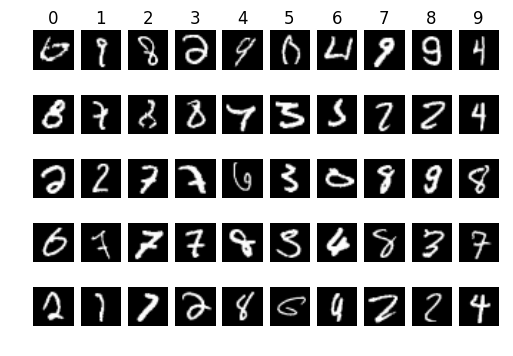

In [14]:
acc, pred, incorrect_pred = sess.run([accuracy, prediction, incorrect_prediction], feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
print("test accuracy: ", acc)

print("Incorrect Prediction Case")
plot_mnist(mnist.test.images, classes=pred, incorrect=incorrect_pred)

## Tensorboard Embedding Projector
Tensorboard에 있는 Embedding Projector를 다뤄보도록 하겠다. 본 모델의 FC Layer의 hidden node 값들을 embedding projector를 통해 살펴보겠다.

In [15]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
from tensorflow.contrib.tensorboard.plugins import projector


features = sess.run(h_fc1, feed_dict={x: x_test, y_: y_test, keep_prob: keep_prob_test})
#features = mnist.test.images

print(features)

embedding_var = tf.Variable(features, name='embedding')

# Tensorflow에서 모든 변수는 초기화 해야한다. 
# embedding_var은 초기화 한적이 없으므로 초기화 한다.
tf.global_variables_initializer().run()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
[[ 0.09833141  0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.943959   ...,  0.          0.          0.        ]
 [ 0.          0.          1.25756752 ...,  0.          1.37708461  0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.18618655 ...,  0.          0.          0.        ]]


## Saver, 훈련이 끝난 모델 저장
Training 한 모델과 embedding vector를 저장하기 위한 객체를 생성한다.<br>

In [16]:
log_dir = 'logs/'

saver = tf.train.Saver() # 저장 대상이 모든 Variables 경우
#saver = tf.train.Saver({"my_v2": v2}) # 저장 대상이 my_v2라는 일부 Variable일 경우


# log directory가 기존에 있다면 삭제하고 다시 만든다.
if tf.gfile.Exists(log_dir):
    tf.gfile.DeleteRecursively(log_dir)
tf.gfile.MakeDirs(log_dir)

save_path = saver.save(sess, log_dir+"model.ckpt")
print("Model saved in file: %s" % save_path)

#저장된 모델을 불러온다.
# saver.restore(sess, log_dir+"/model.ckpt")

Model saved in file: logs/model.ckpt


In [17]:
# embedding data 추가
log_dir = 'logs/'
summary_writer = tf.summary.FileWriter(logdir=log_dir, graph=tf.get_default_graph())
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

In [18]:
# # label data 추가
metadata_path = 'logs/metadata.tsv'
with open(metadata_path, 'w') as f:
    for i, label in enumerate(mnist.test.labels):
        f.write('{}\n'.format(label))
embedding.metadata_path = metadata_path

In [19]:
# sprite image 추가
embedding.sprite.image_path = './assets/mnist/mnist_10k_sprite.png'
embedding.sprite.single_image_dim.extend([28, 28]) # 가로:28, 높이:28

In [20]:
# visualize embedding projector
projector.visualize_embeddings(summary_writer, config)

### Tensorboard 실행
activate tensorflow (맥에서는 source activate tensorflow)<br>
tensorboard --logdir=./logs <br>
실행 후 웹에서 localhost:6006 으로 접속한다. <br>
(Training에 관한 정보는 tensorboard --logdir=./train 으로 접속해서 확인할 수 있다.)

![](CNN_1/embedding_mnist.png)
<그림 3. Tensorboard Embedding Projector 예시>